In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import AA_Import_LCP_Functions as chase_lcc
import AB_Import_Prep_XGB_Tune as chase_xgb_tune

# Read in prmtop and tractory data and execute internal distance measurements
-----
### CPPTRAJ files saved in cpptraj_folder
### LCCDATA files saved in lccdata_folder

In [2]:
# Configuration
prmtop_1 = 'myc_091-160_stripped.prmtop'
nc_1 = 'aMD_091-160_no1-4_stripped.nc'
prmtop_2 = 'myc_091-160_D132-H_stripped.prmtop'
nc_2 = 'aMD_091-160_D132-H_no1-4_stripped.nc'
protein_length = 70
window_range = range(2, 52)

# Setup folders and execute scripts
cpptraj_folder, lccdata_folder, should_proceed = chase_lcc.setup_folders()
if should_proceed:
    chase_lcc.execute_cpptraj_scripts(prmtop_1, nc_1, prmtop_2, nc_2, protein_length, window_range, cpptraj_folder, lccdata_folder)
else:
    print("No need to regenerate cpptraj scripts or lccdata files.")

cpptraj files and lccdata_files already generated.
No need to regenerate cpptraj scripts or lccdata files.


In [3]:
# Create LCCDATA files
chase_lcc.execute_cpptraj_commands(cpptraj_folder, window_range)

cpptraj files and lccdata_files already generated.


# Load LCCDATA and attach to variables wt_dict[window] and D132H_dict[window]

In [4]:
lccdata_folder = 'lccdata_files'

# Import LCC data files for wild type protein and mutant protein
wt_dict = chase_lcc.import_lcc_data(lccdata_folder, 'w')
D132H_dict = chase_lcc.import_lcc_data(lccdata_folder, 'm')

# Create Local Compaction Plots

In [5]:
save_folder = 'Local_Compaction_Plot_Figures'
if not (os.path.isdir(save_folder) and len(os.listdir(save_folder)) == 50):
    for window in window_range:
        chase_lcc.LCC_plot_individual(window, wt_dict[window], D132H_dict[window], save_folder)
else:
    print("Local compaction plots already generated and saved in 'Local_Compaction_Plot_Figures'")

Local compaction plots already generated and saved in 'Local_Compaction_Plot_Figures'


# Feature Engineering:

#### XGBoost Hyperparameter Evaluation
- Pre-prepares data
- Runs XGBoost on each window size with default hyperparameters
- Performs XGBoost hyperparameter tuning
- Generates figures to compare the performance of hyperparameters

In [6]:
trainer = chase_xgb_tune.XGBoostTrainer(
    wt_dict=wt_dict,
    D132H_dict=D132H_dict,
    window_sizes=range(2, 52),
    default_hyperparameters={'use_label_encoder': False, 'eval_metric': 'logloss'},
    eta_values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    max_depth_values=[6, 9, 12, 15, 18, 21, 24],
    subsample_values=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
)

In [7]:
# This cell takes ~39 minutes to tune and run if the trial number does not exist
try:
    trainer.load_tuning_results(1)  # Loads trial information if trial # exists
except FileNotFoundError as e:
    print(e)
    print("Running new tuning session instead.")
    trainer.tune_hyperparameters_and_save()

# Evaluate default hyperparameters after either loading or tuning
trainer.evaluate_default_hyperparameters()


Tuning results loaded from XGB_Tuning/XGB_Tuning_Trial_1/tuning_results.json


Possible values for Eta: [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]


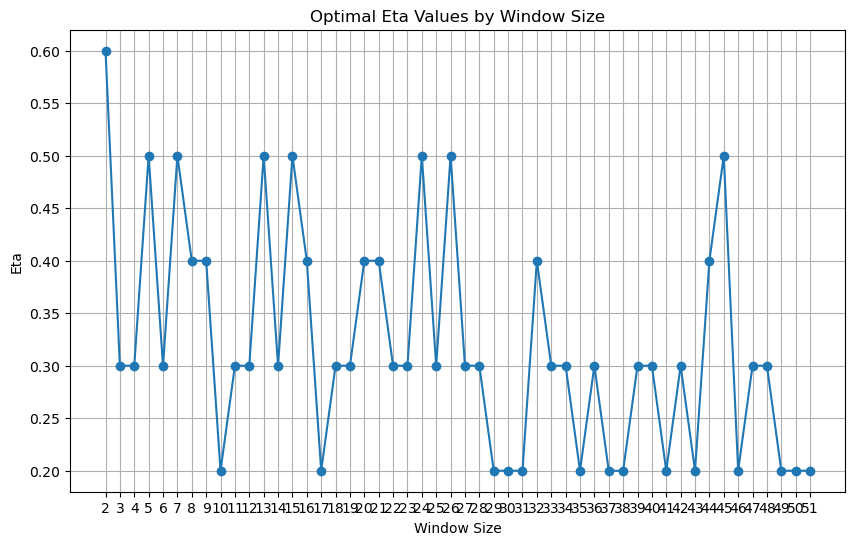

Possible values for Max Depth: [6, 9, 12, 15, 18, 21, 24]


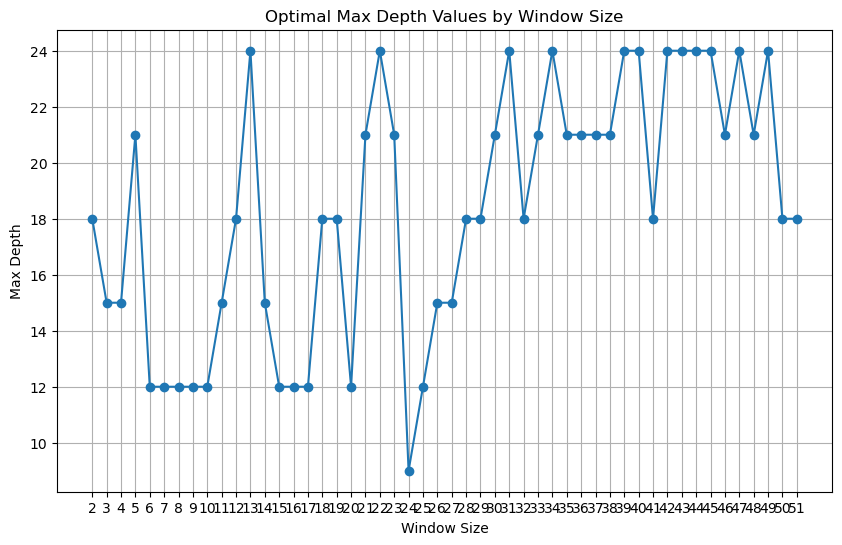

Possible values for Subsample: [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]


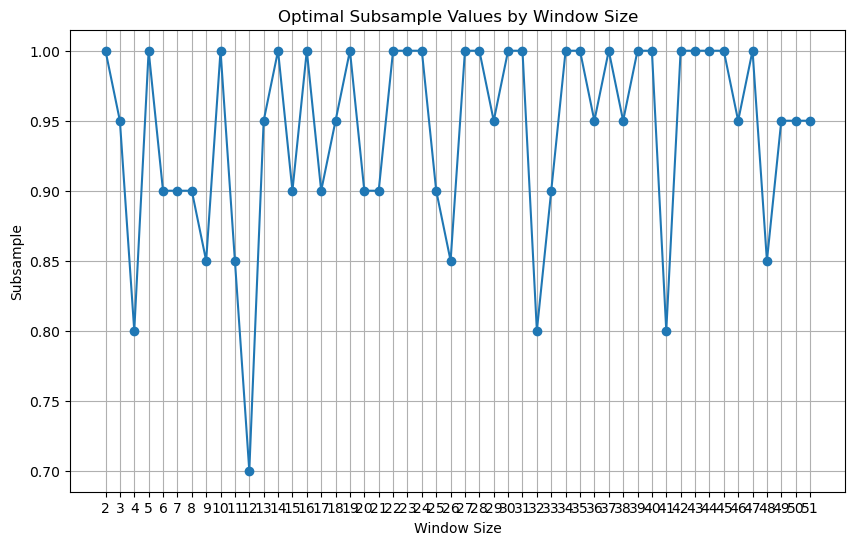

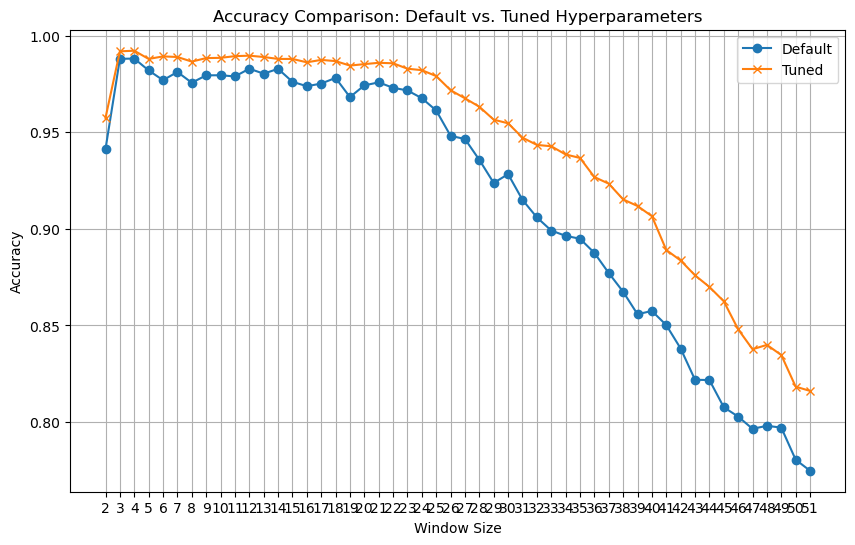

Average accuracy with default hyperparameters: 0.9168
Average accuracy with tuned hyperparameters: 0.9429


In [8]:
# Plot best hyperparameter values for each window size
trainer.plot_specific_hyperparameter_values(trainer.best_eta_values, 'Optimal Eta Values by Window Size', 'Eta', trainer.eta_values)
trainer.plot_specific_hyperparameter_values(trainer.best_max_depth_values, 'Optimal Max Depth Values by Window Size', 'Max Depth', trainer.max_depth_values)
trainer.plot_specific_hyperparameter_values(trainer.best_subsample_values, 'Optimal Subsample Values by Window Size', 'Subsample', trainer.subsample_values)

# The overall best accuracy by window size plot can be achieved with the existing method
trainer.plot_hyperparameter_values(trainer.window_sizes, trainer.default_accuracy_values, trainer.best_accuracy_values, 'Accuracy Comparison: Default vs. Tuned Hyperparameters')

# Calculate and display average accuracies
average_default_accuracy = np.mean(list(trainer.default_accuracy_values.values()))
average_tuned_accuracy = np.mean(list(trainer.best_accuracy_values.values()))
print(f"Average accuracy with default hyperparameters: {average_default_accuracy:.4f}")
print(f"Average accuracy with tuned hyperparameters: {average_tuned_accuracy:.4f}")

### Extracting Feature Importances

In [9]:
# Specify which hyperparameters to use based on above
manual_hyperparameters = {
    'n_estimators': 100,
    'max_depth': 15,
    'min_child_weight': 1,
    'subsample': 0.95,
    'eta': 0.7,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Specify the base feature importance threshold
importance_threshold = 0.07

# Save important features with adjusted thresholds for each window size
trainer.save_important_features_and_plot(importance_threshold, manual_hyperparameters)

Window size 2: 1 positions saved
Window size 3: 2 positions saved
Window size 4: 1 positions saved
Window size 5: 1 positions saved
Window size 6: 1 positions saved
Window size 7: 1 positions saved
Window size 10: 1 positions saved
Window size 11: 2 positions saved
Window size 12: 2 positions saved
Window size 13: 1 positions saved
Window size 14: 1 positions saved
Window size 15: 1 positions saved
Window size 16: 1 positions saved
Window size 18: 1 positions saved
Window size 19: 1 positions saved
Window size 20: 1 positions saved
Window size 21: 1 positions saved
Window size 22: 1 positions saved
Window size 23: 1 positions saved
Window size 24: 1 positions saved
Total positions saved: 23


### Position importance for each window size

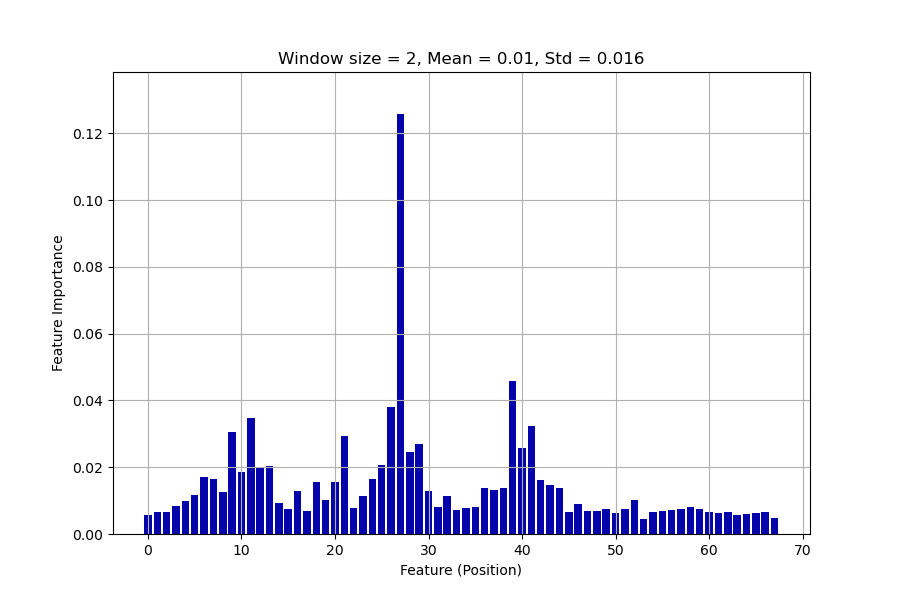

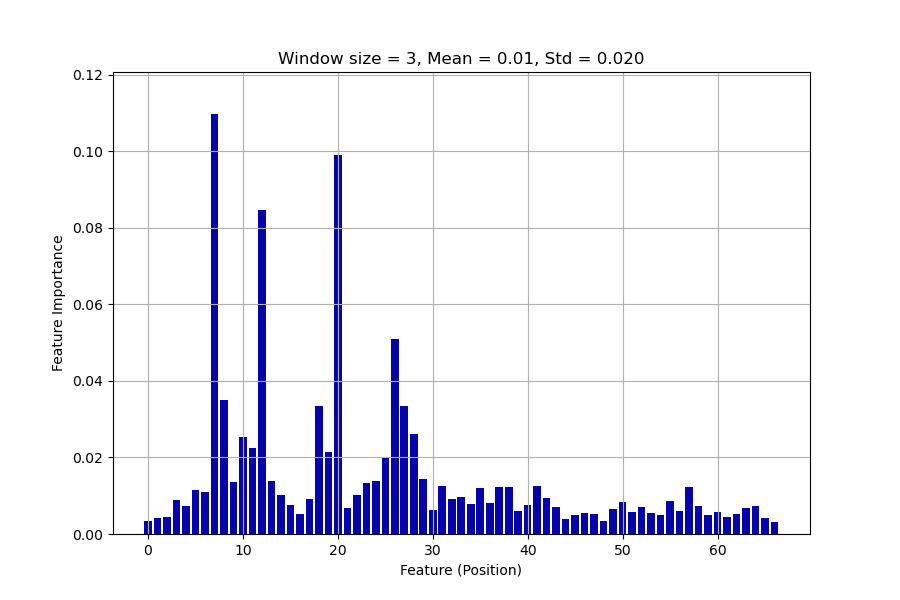

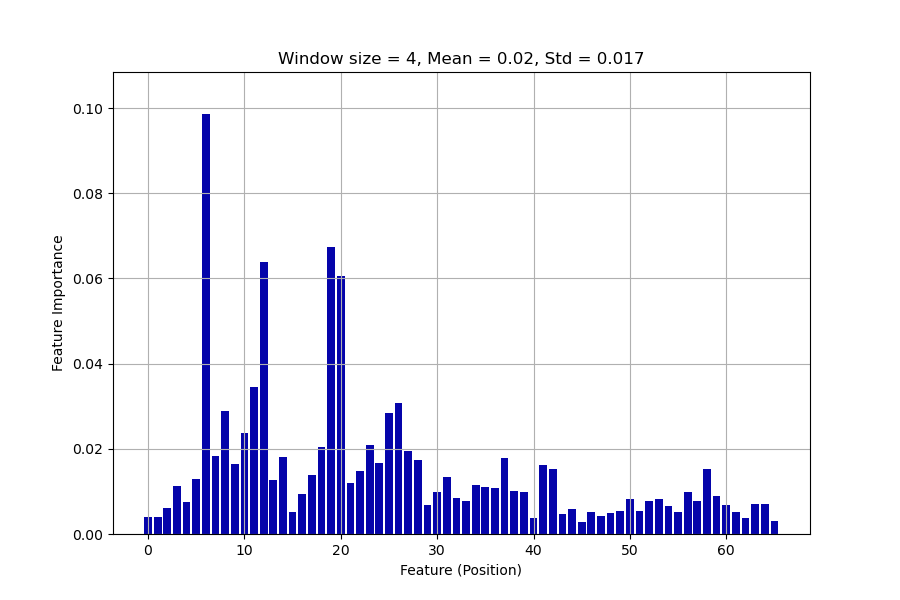

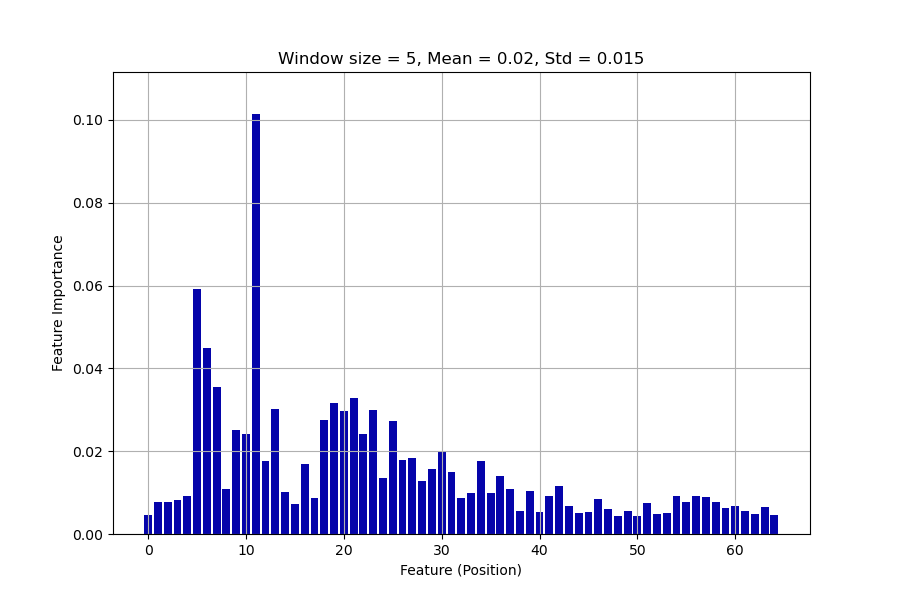

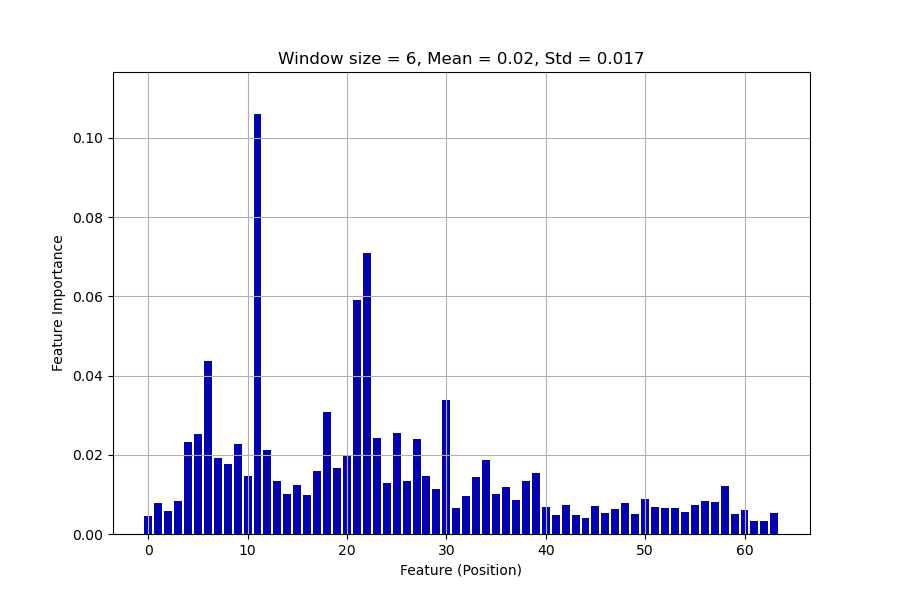

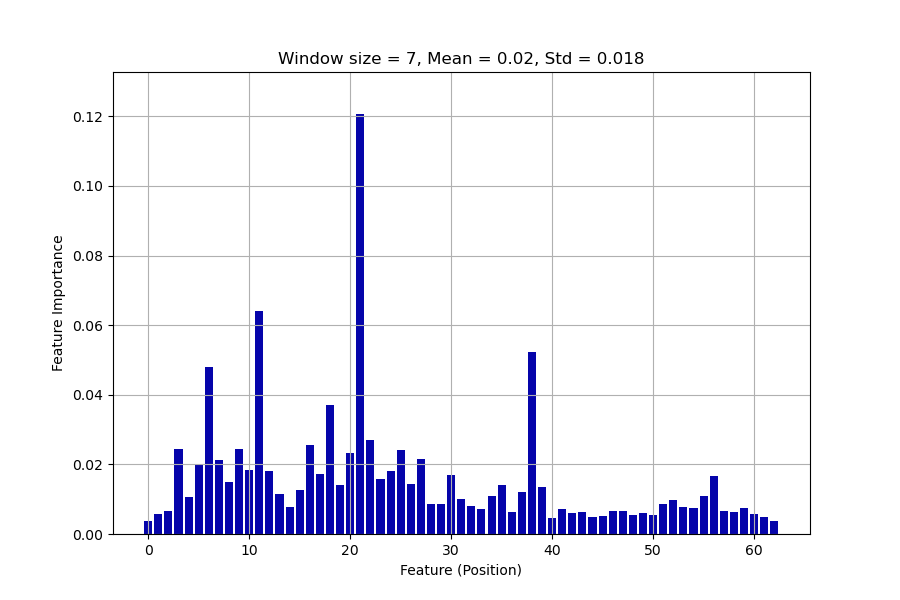

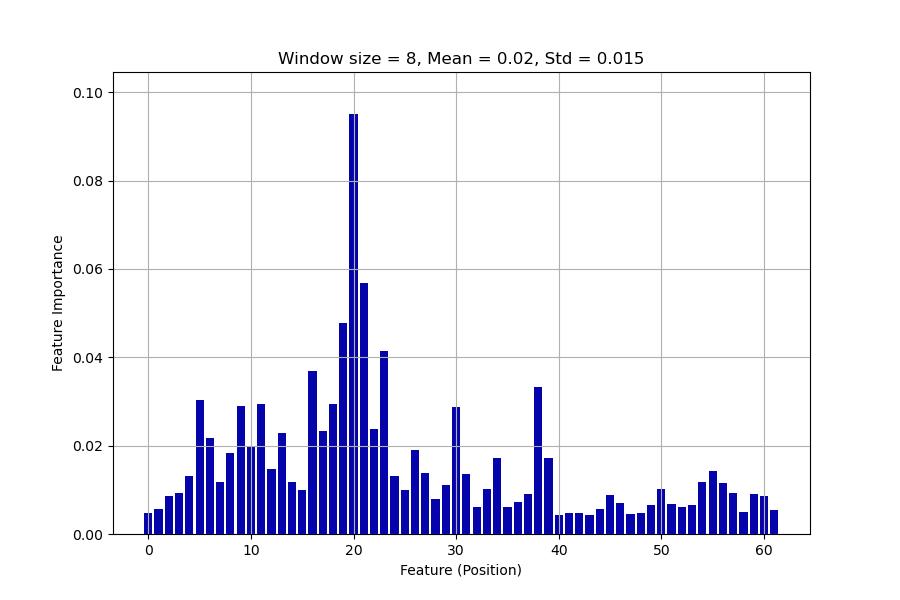

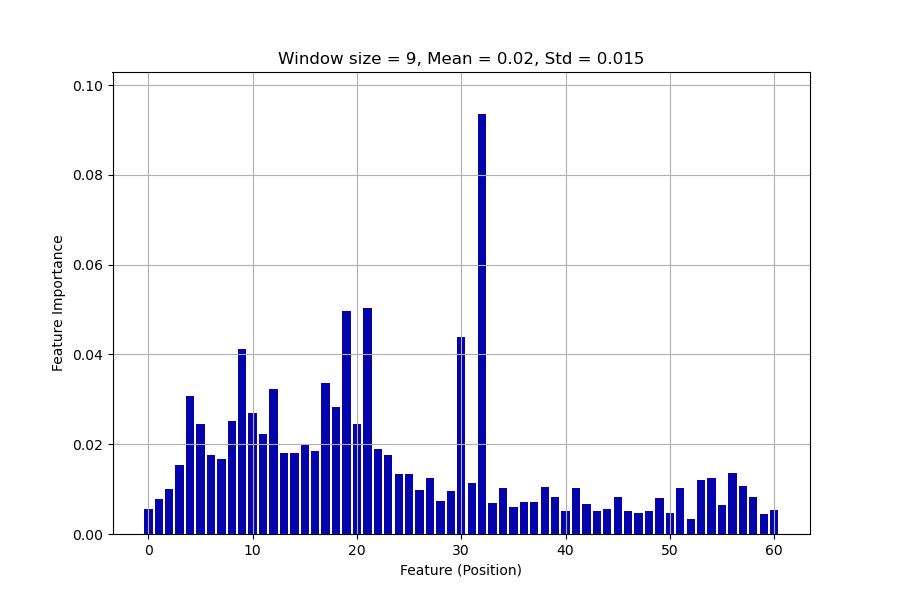

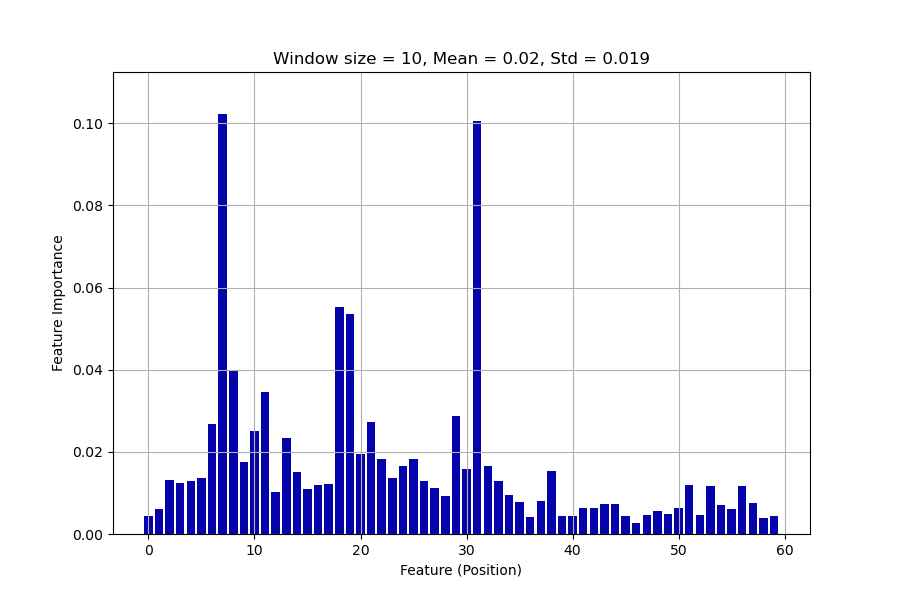

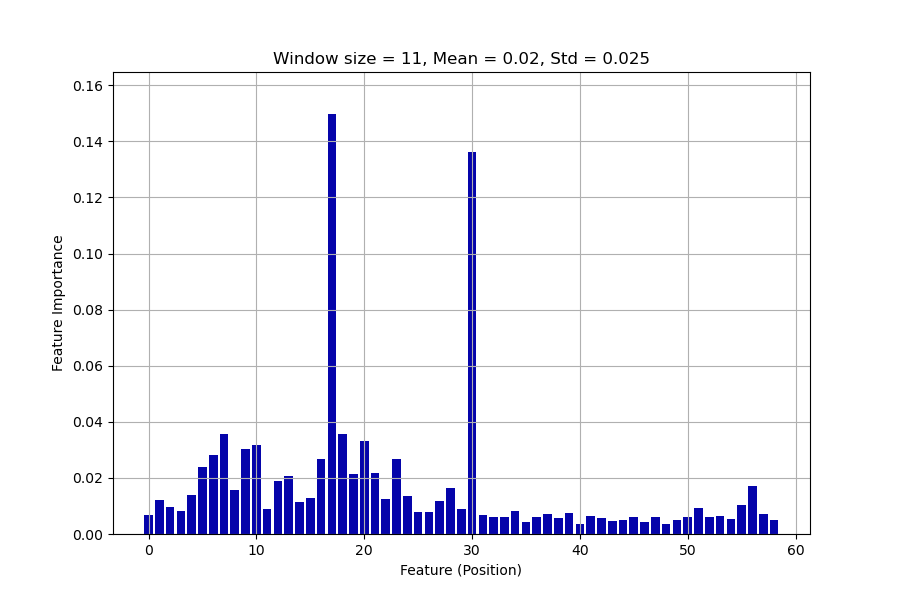

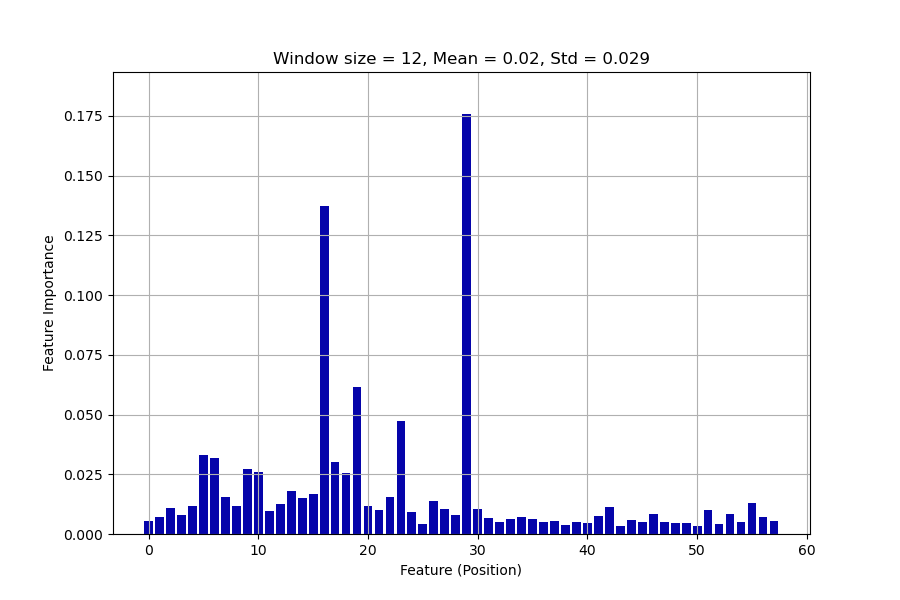

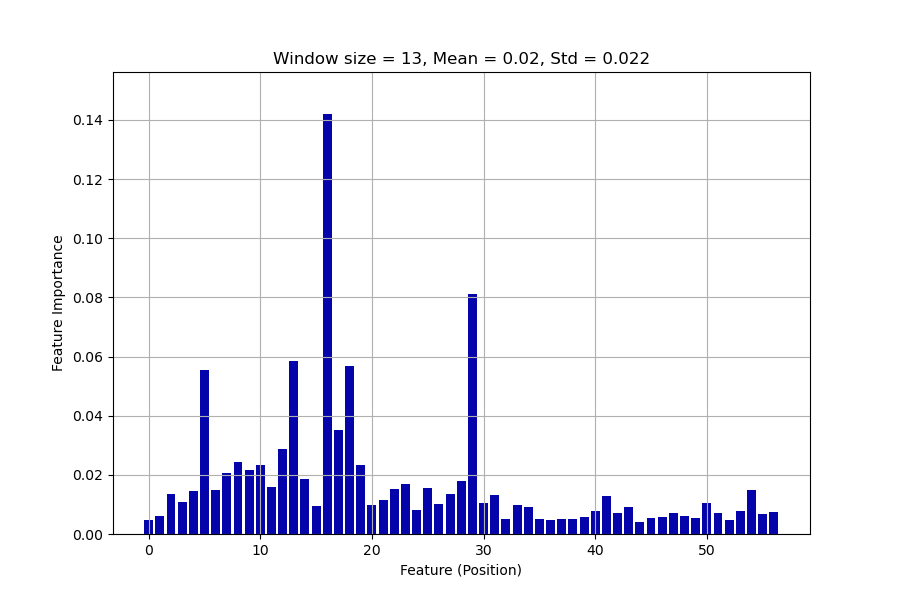

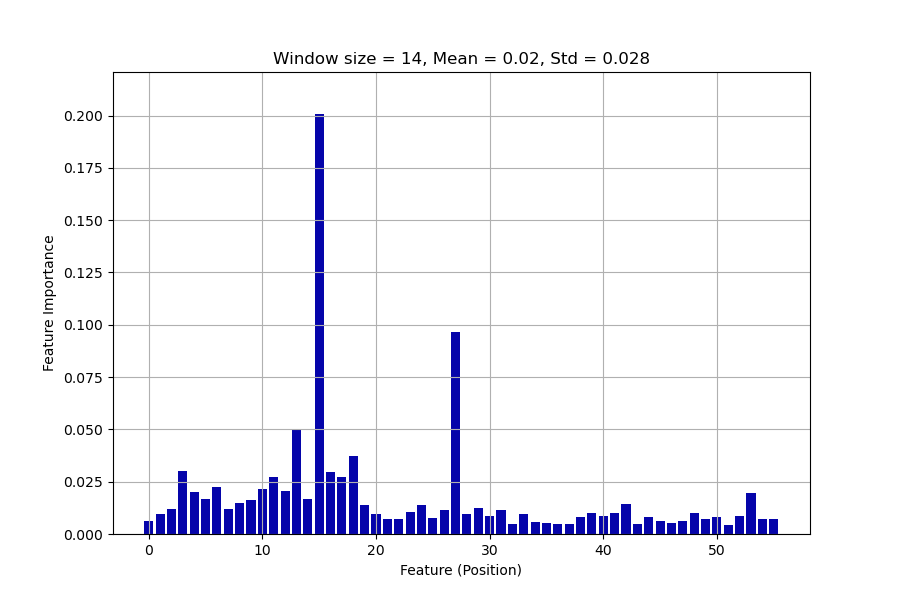

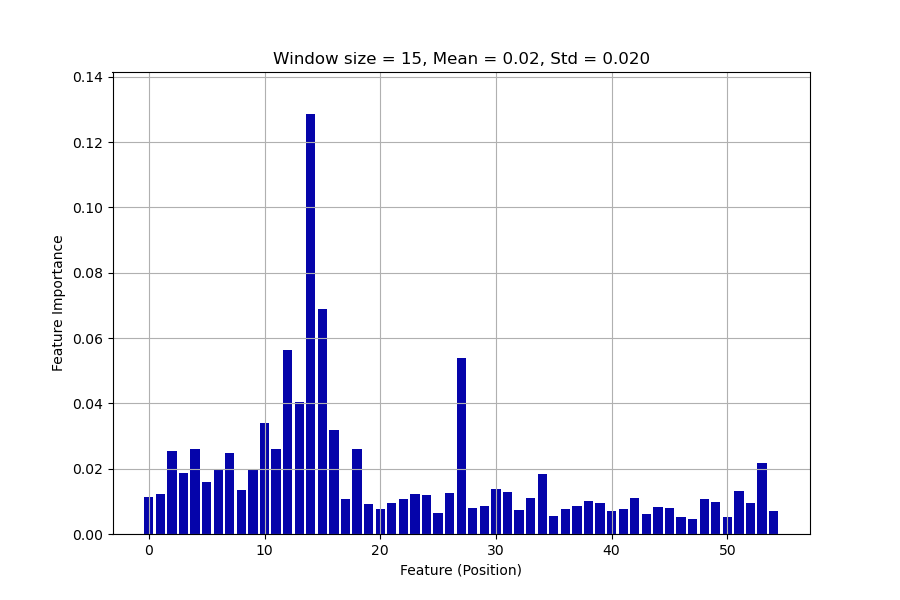

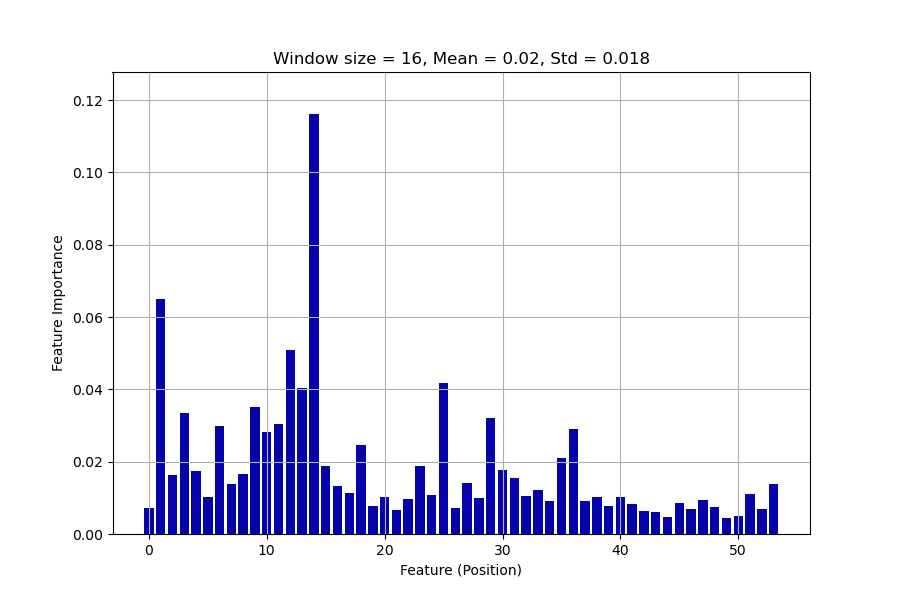

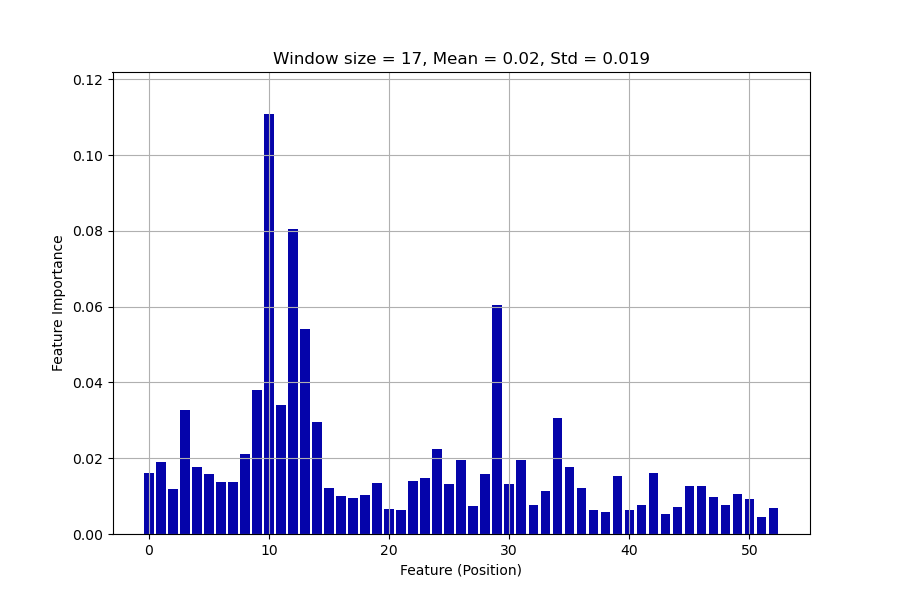

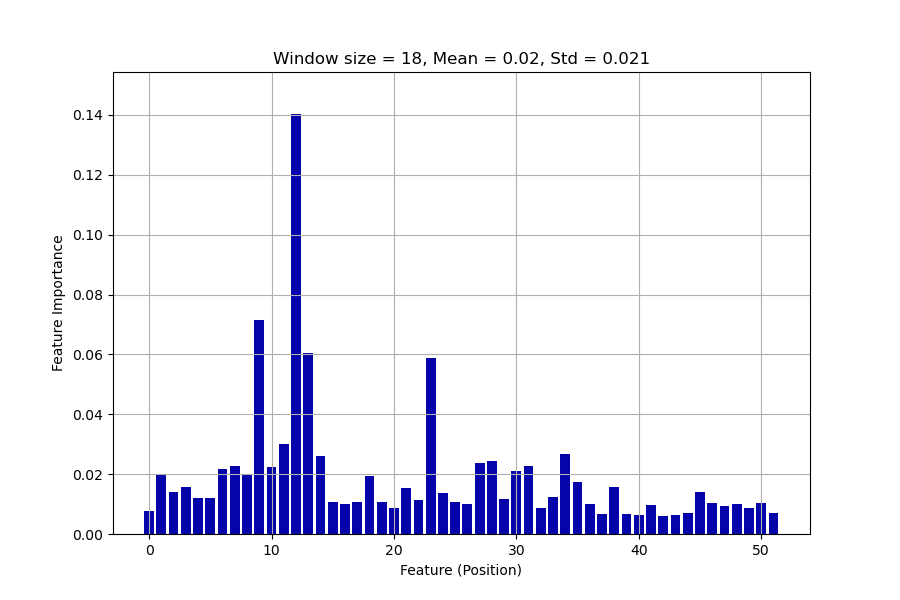

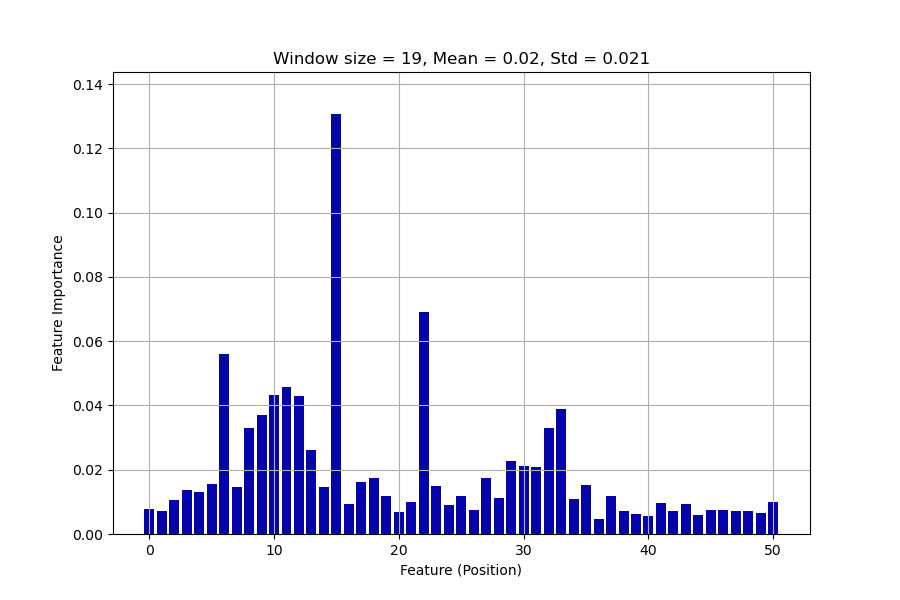

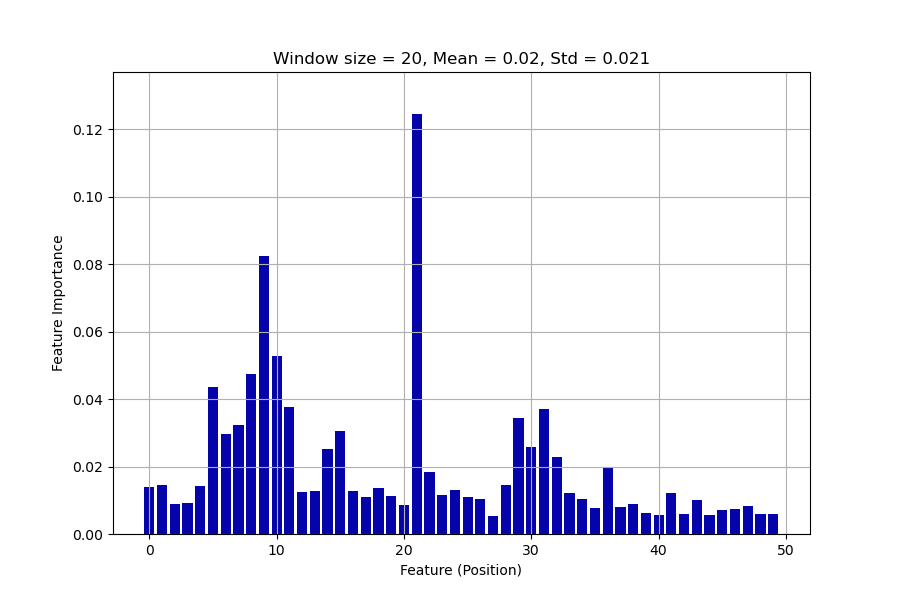

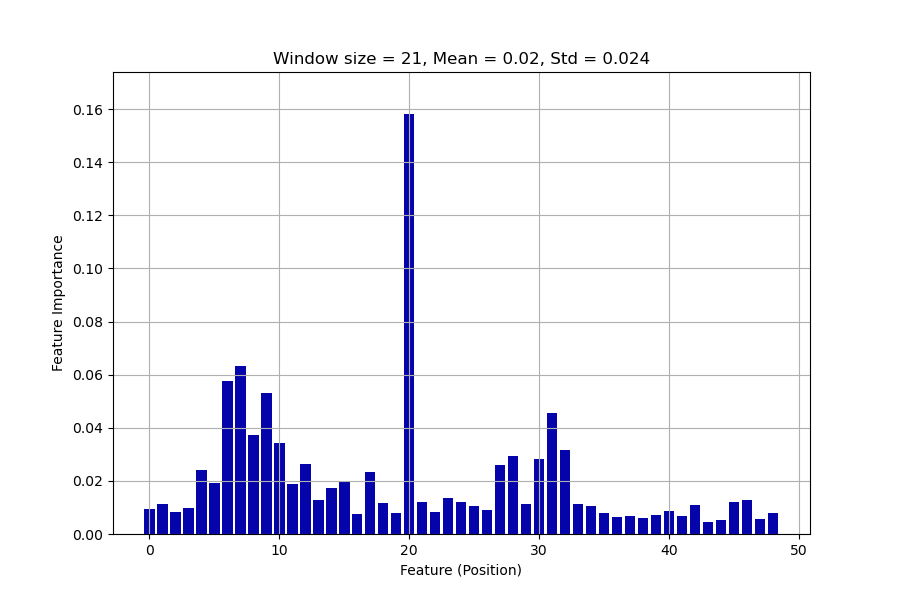

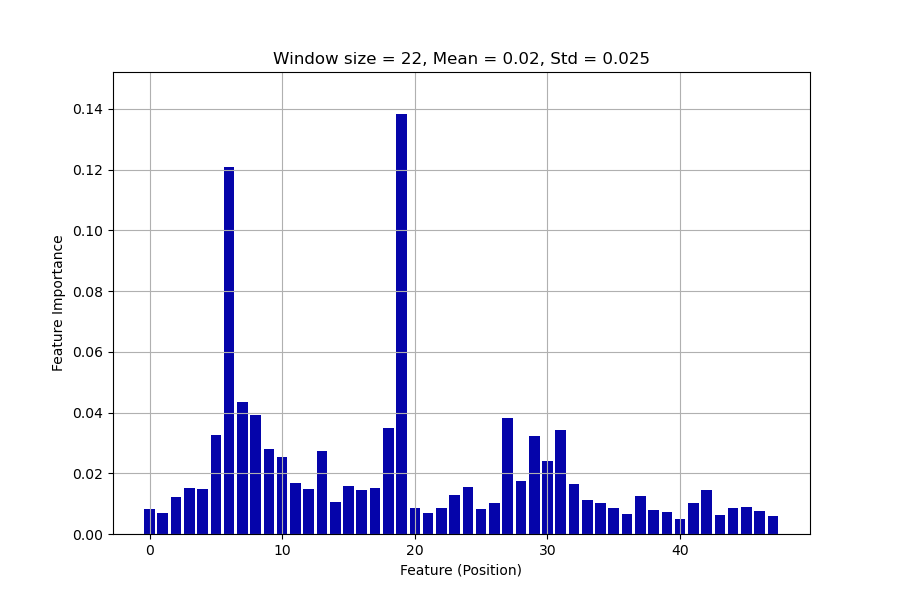

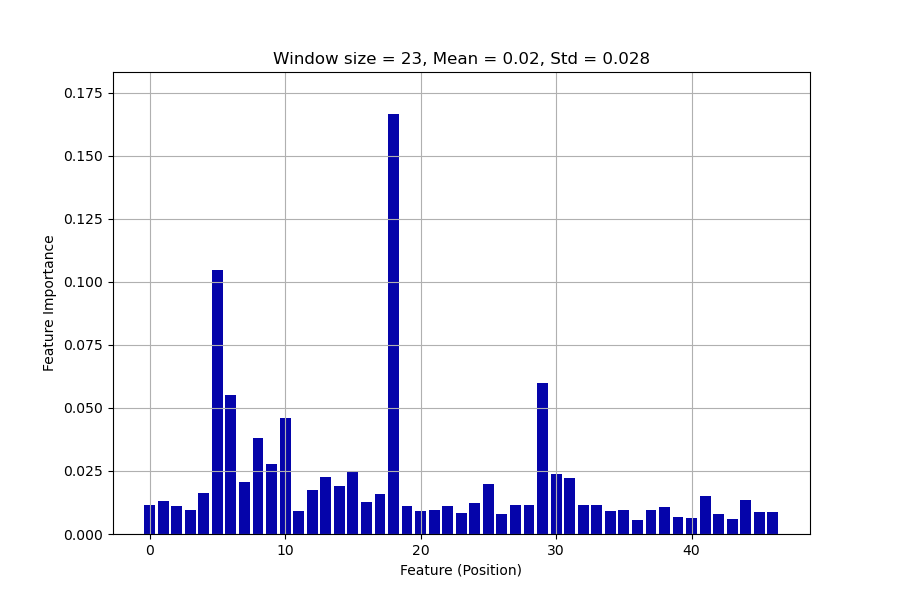

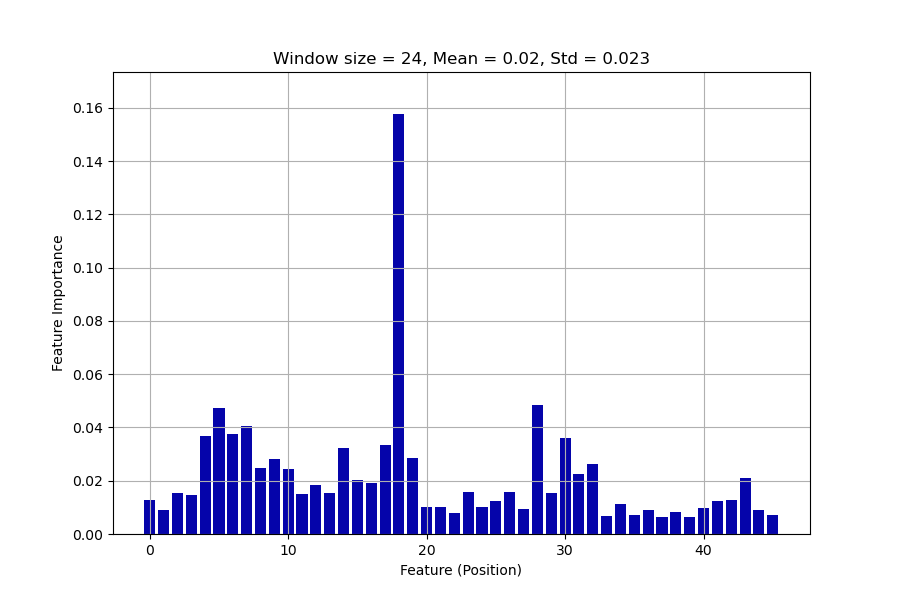

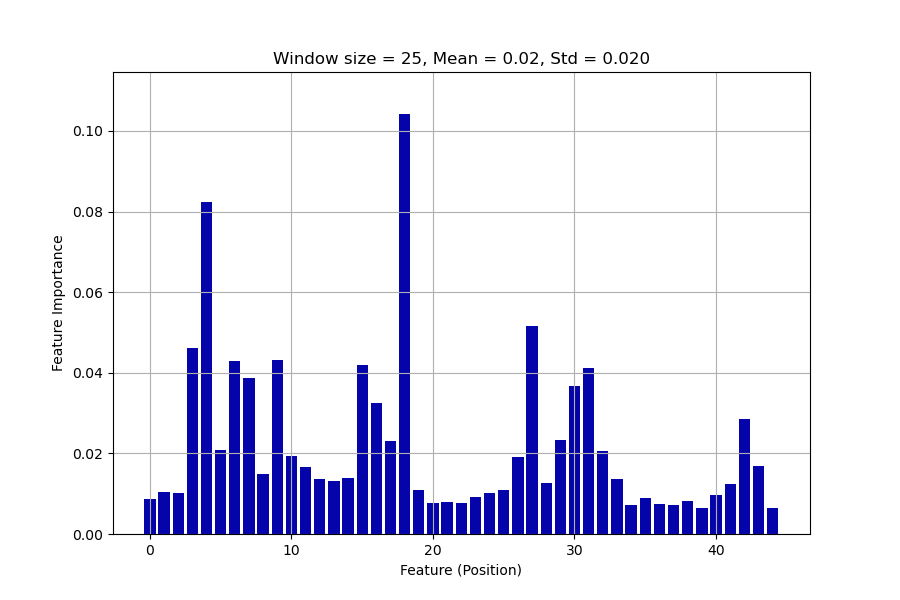

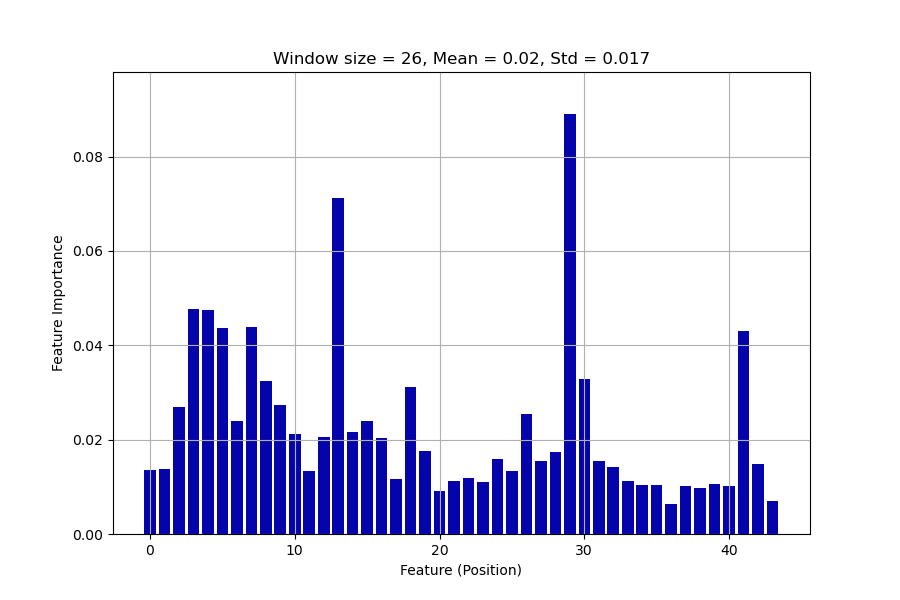

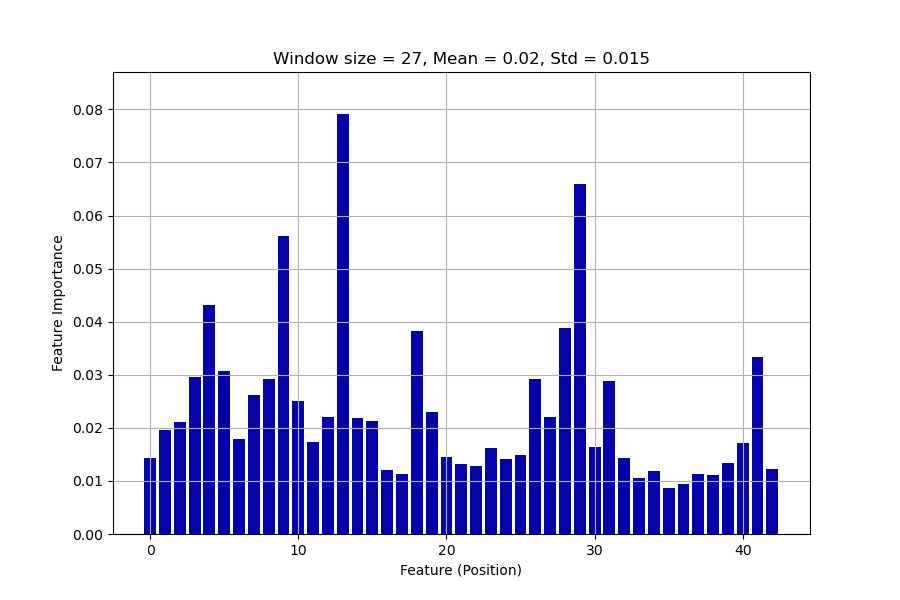

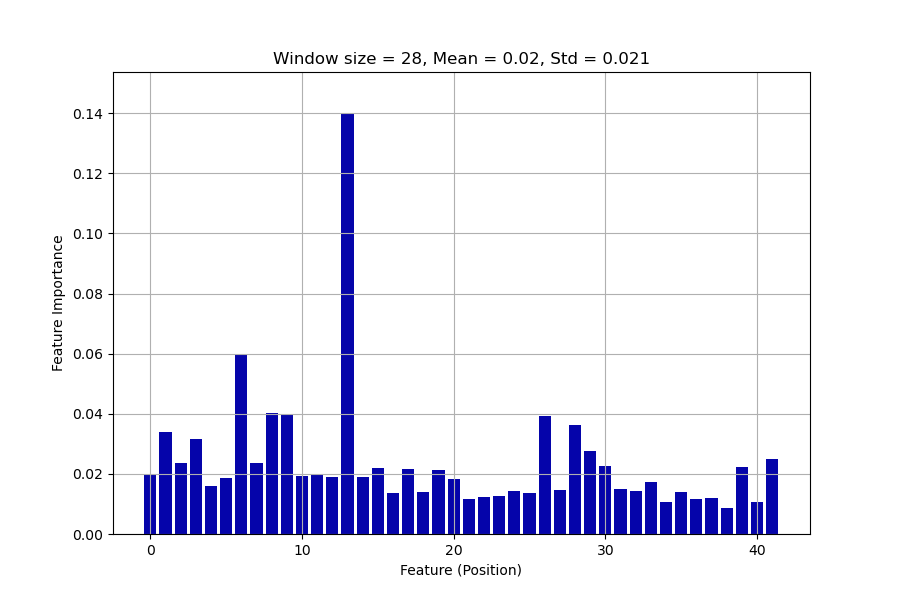

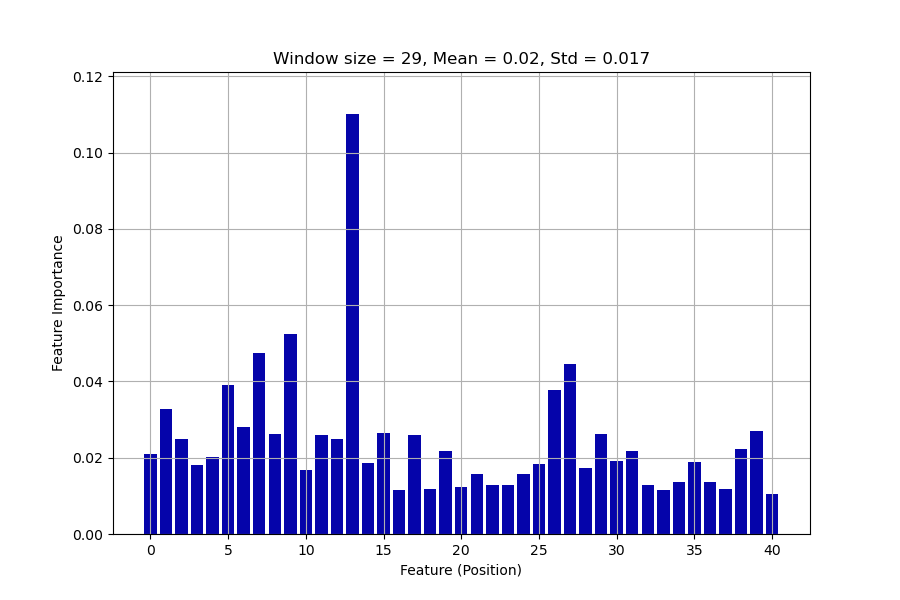

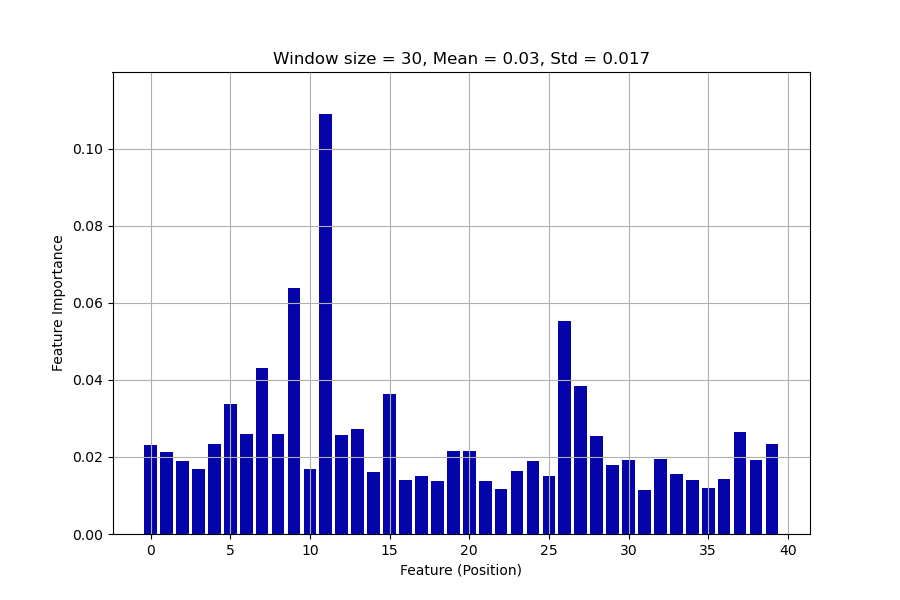

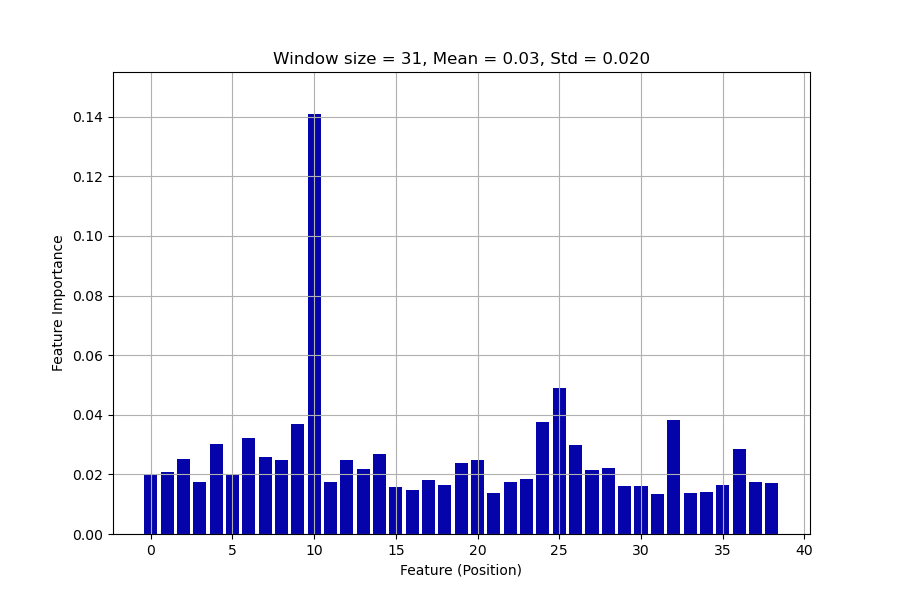

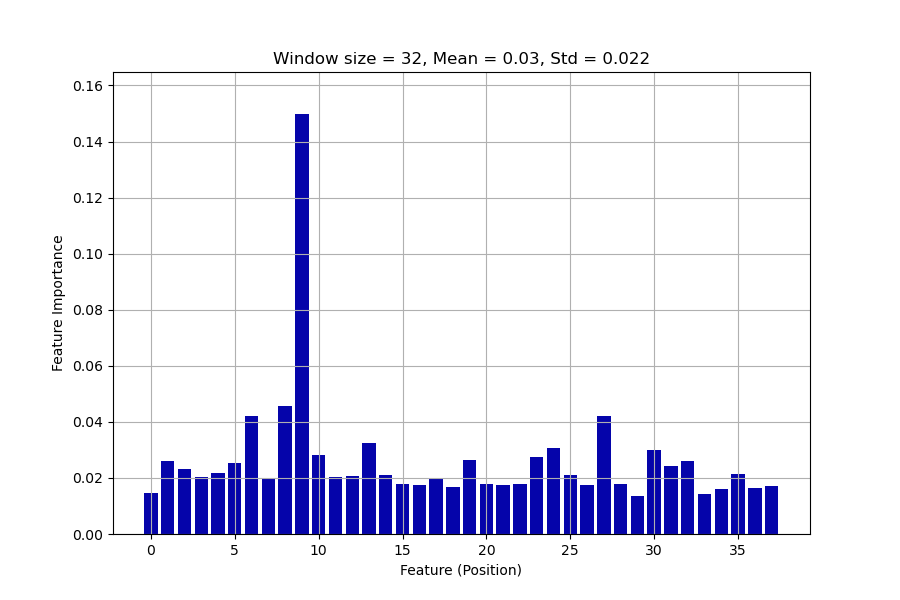

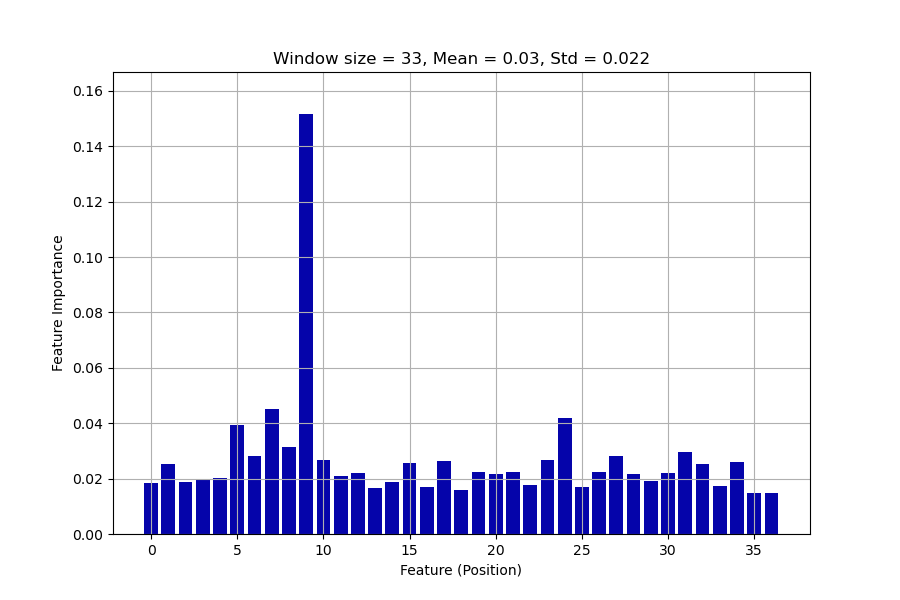

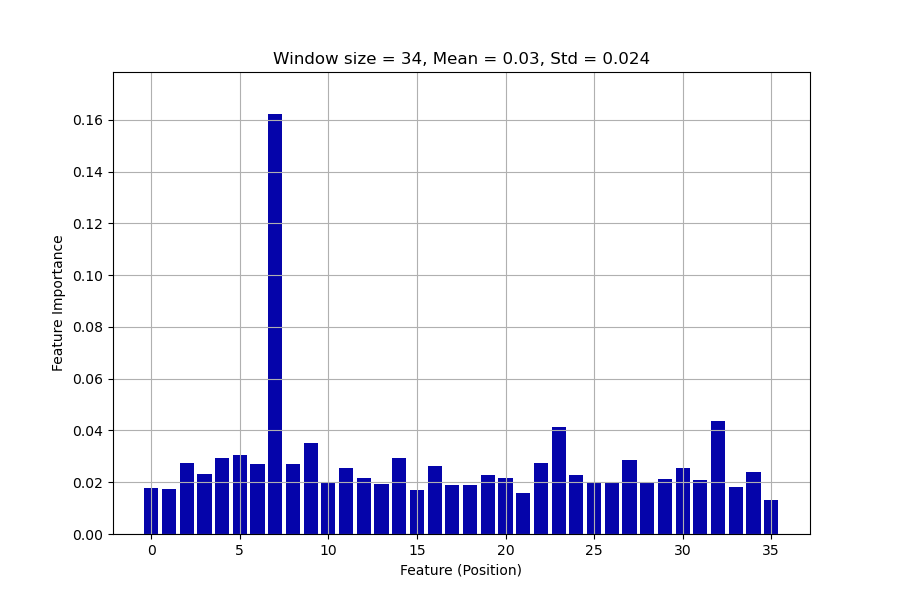

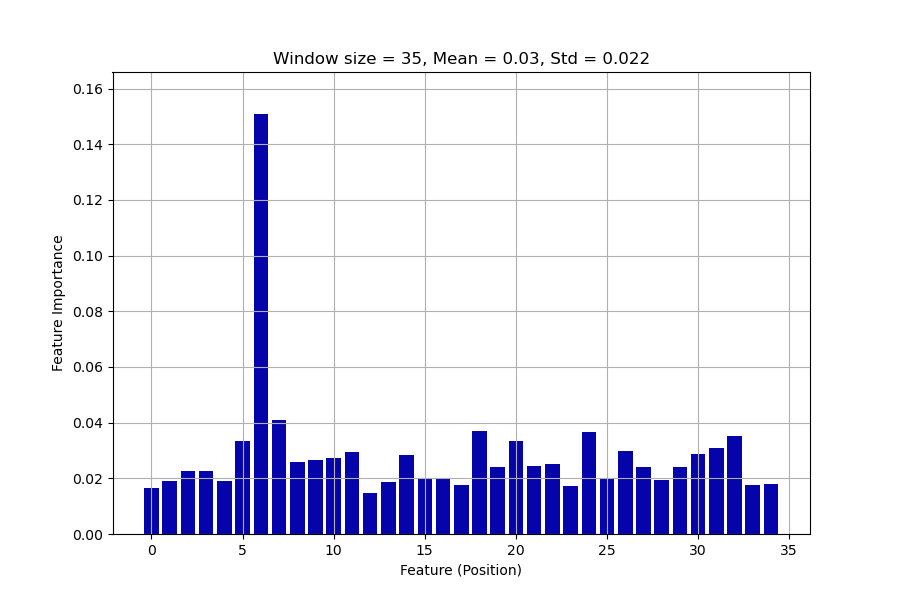

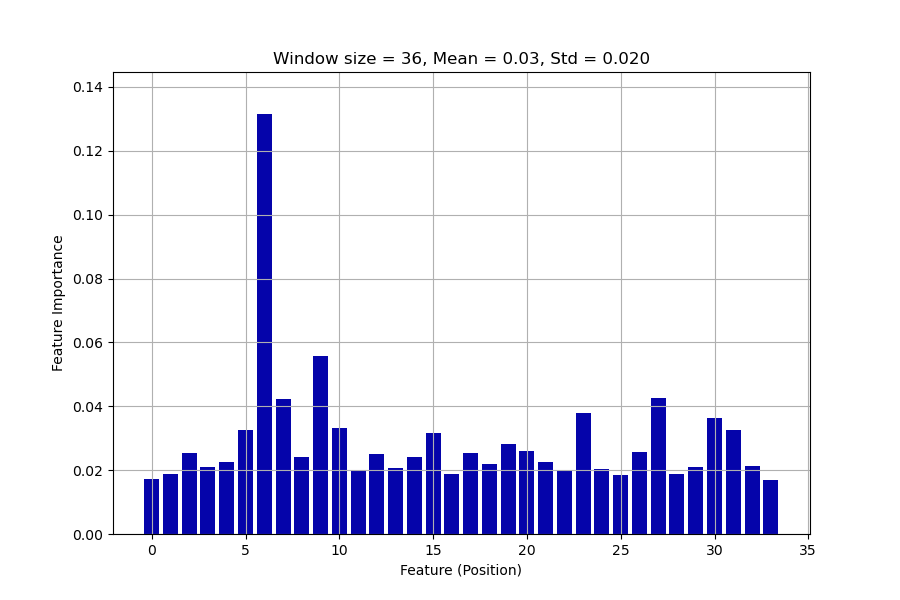

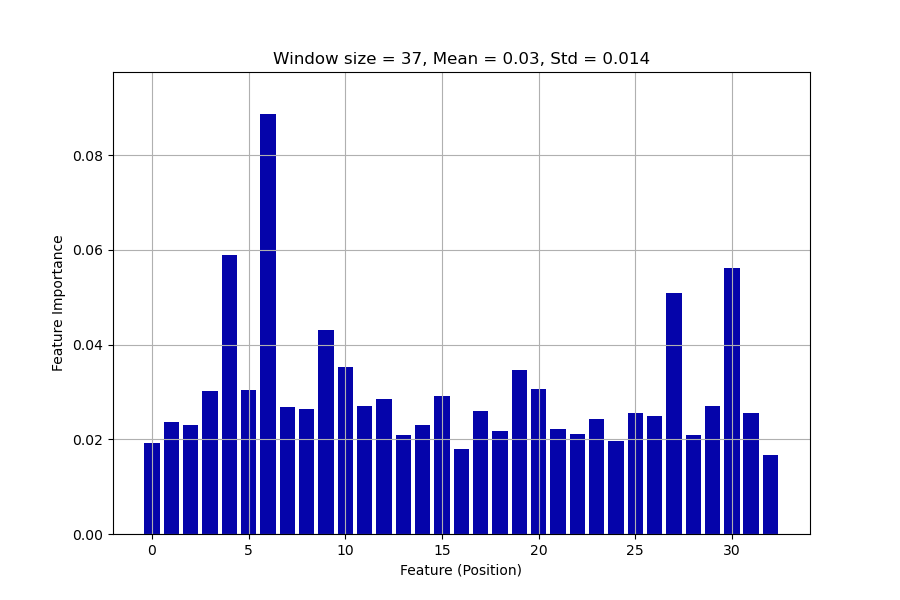

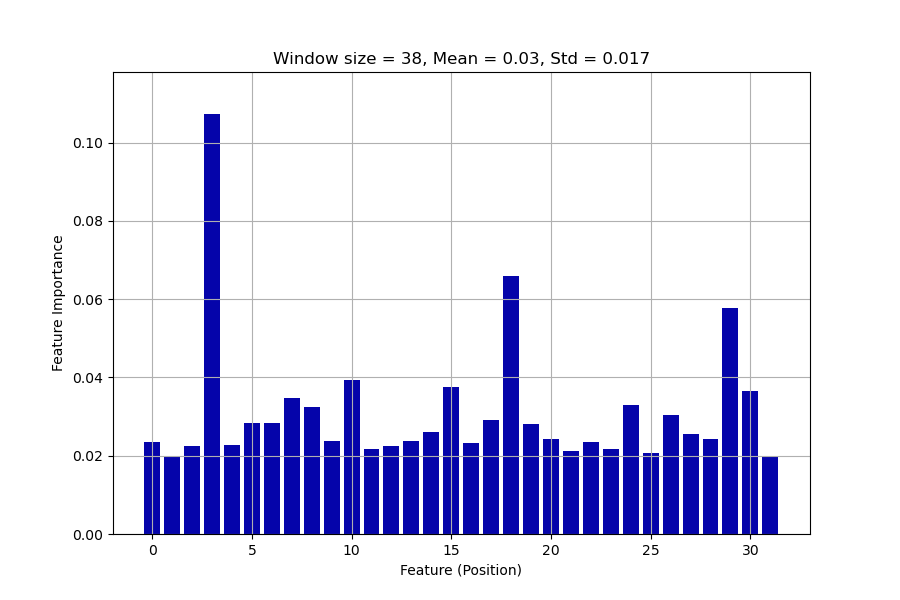

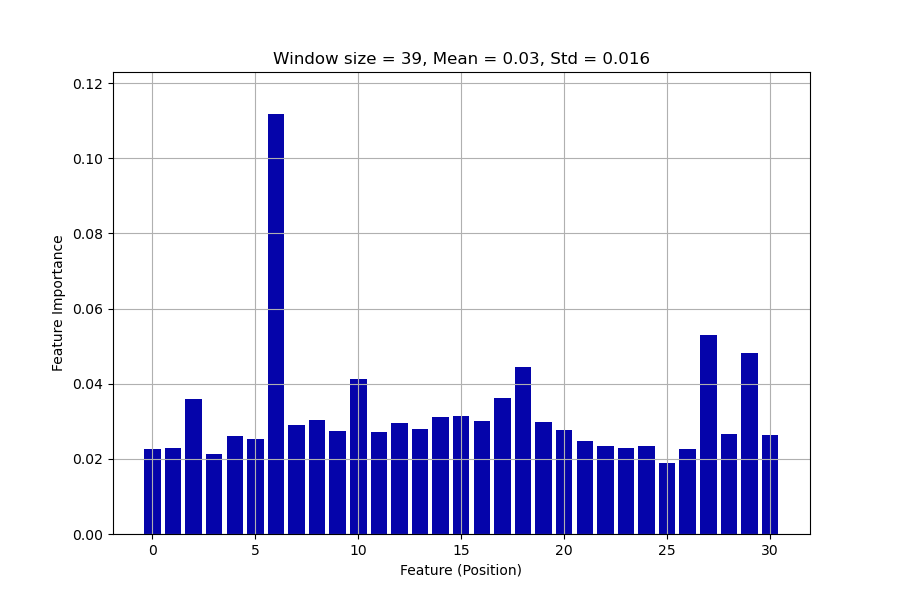

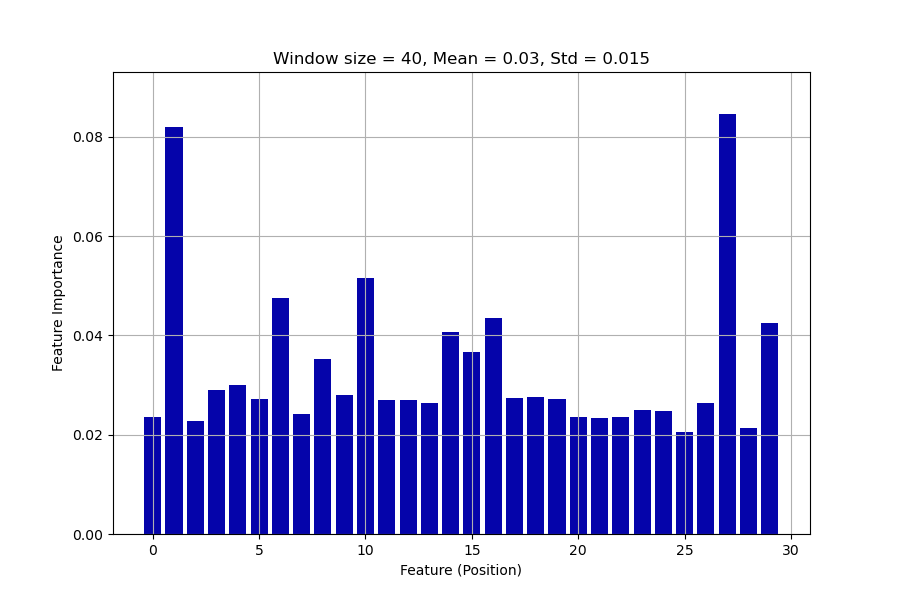

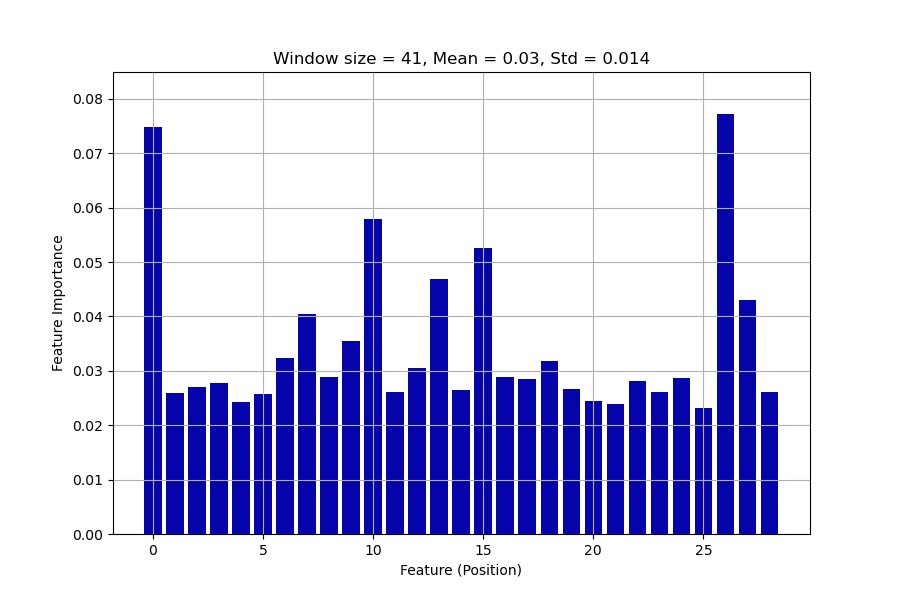

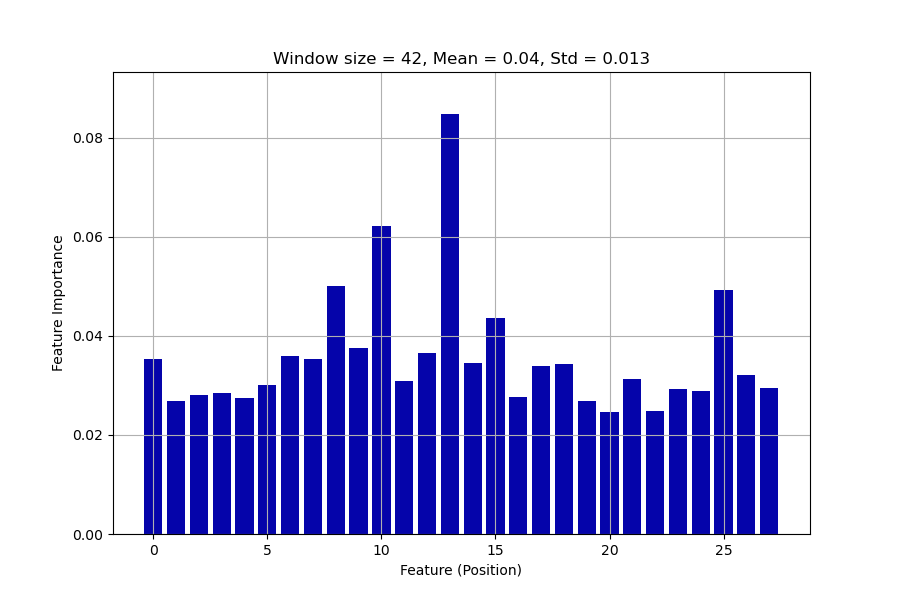

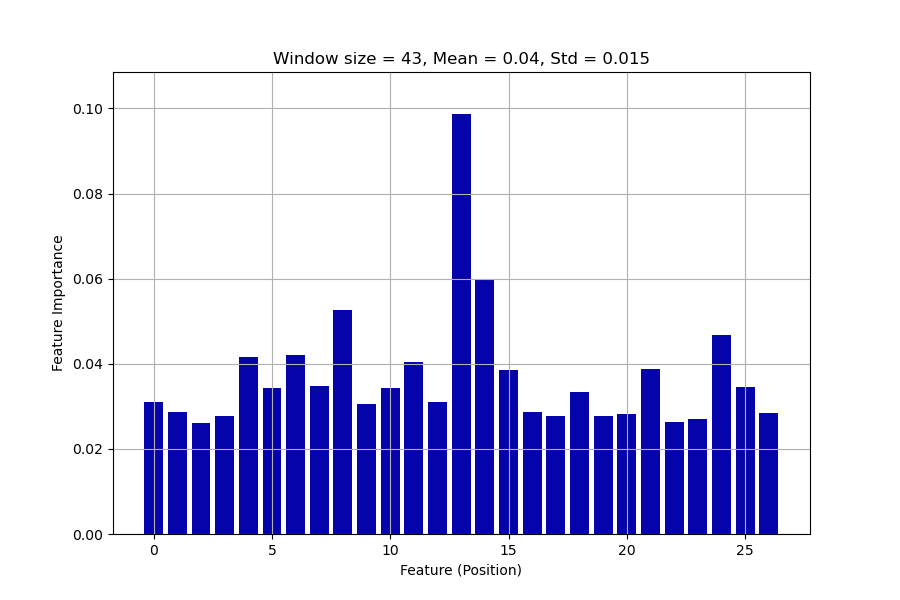

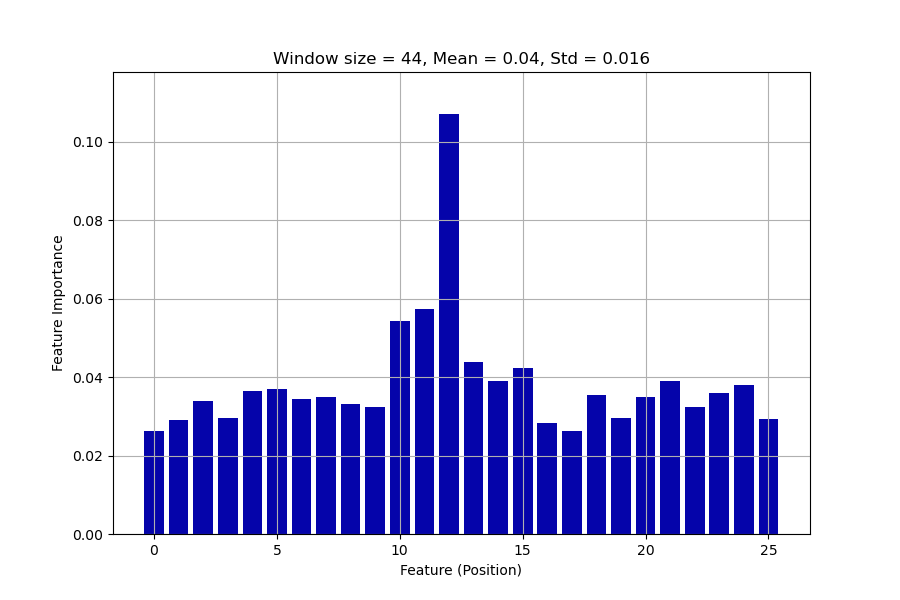

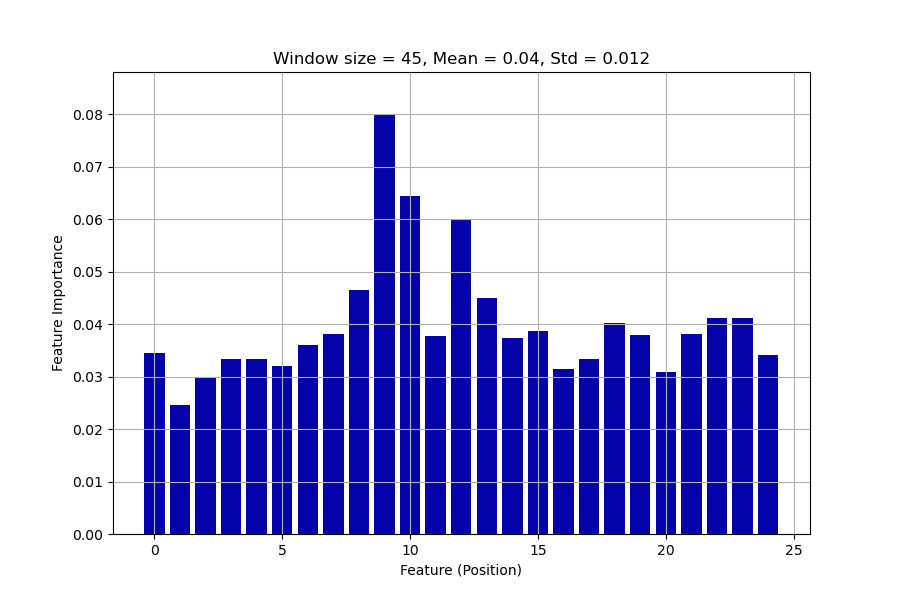

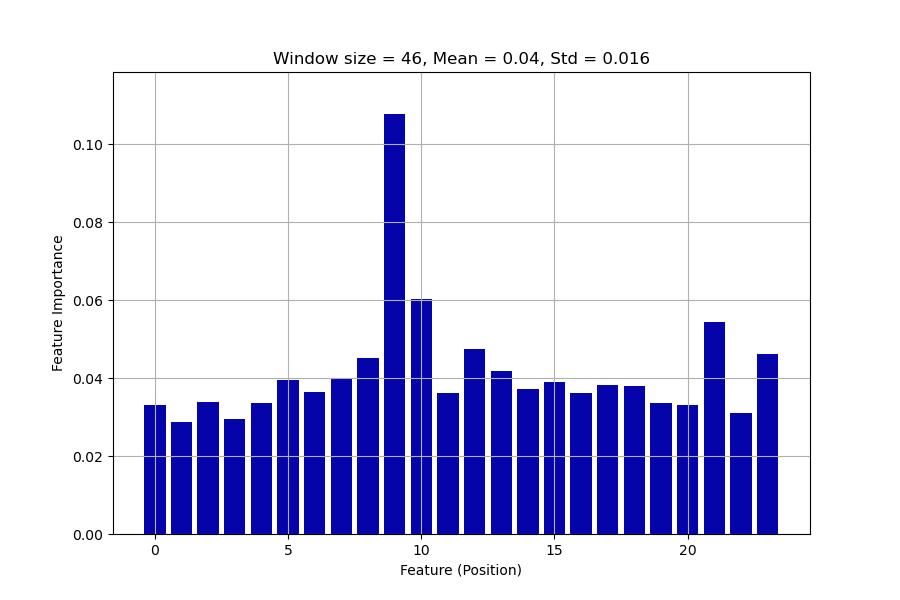

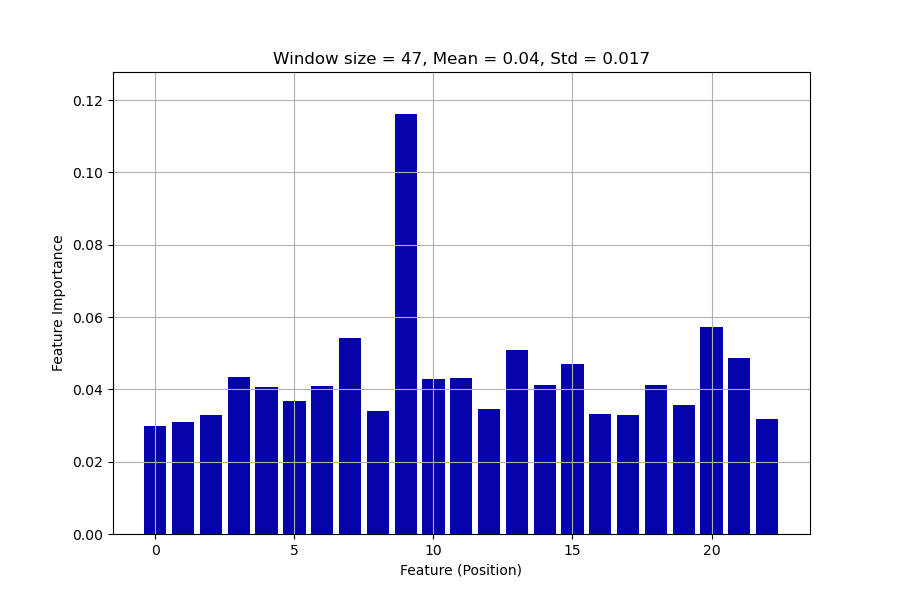

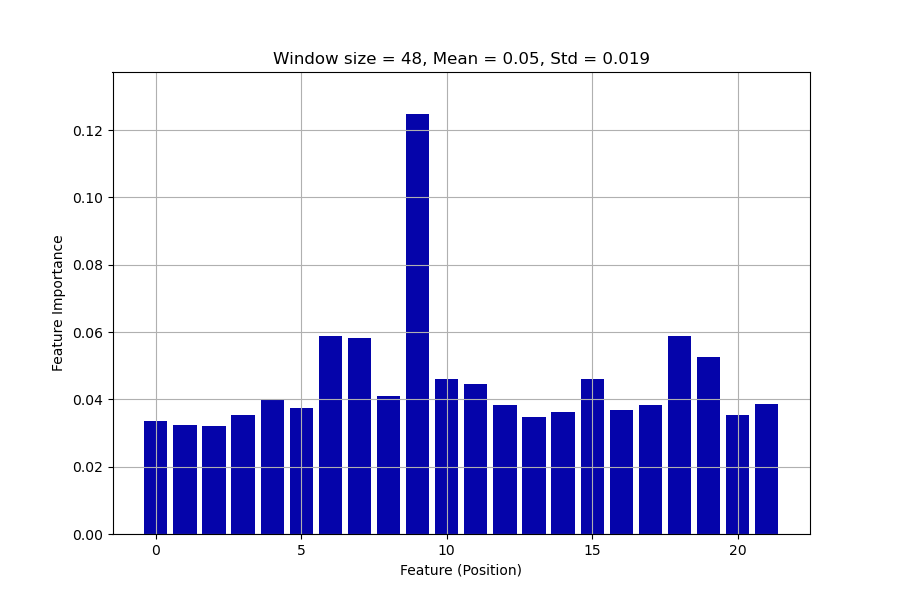

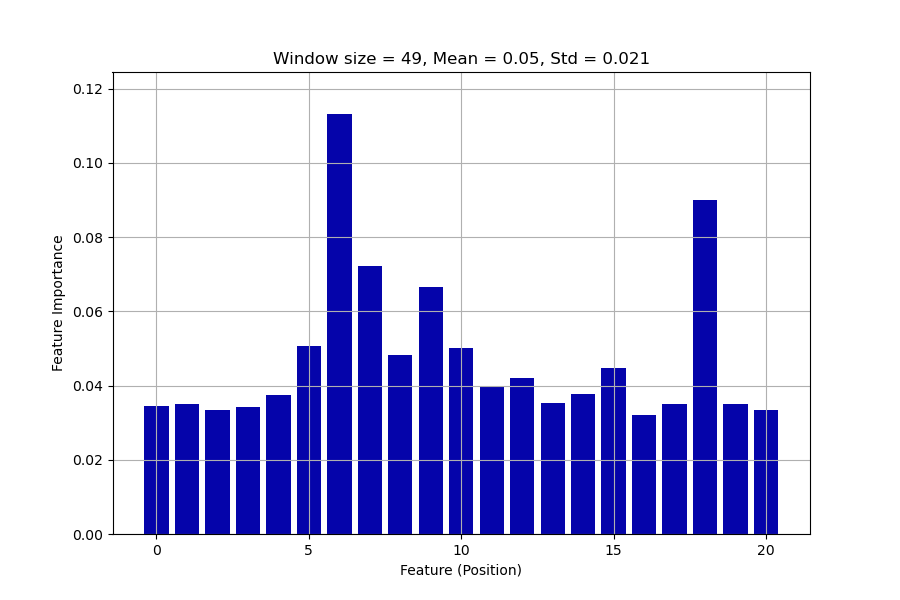

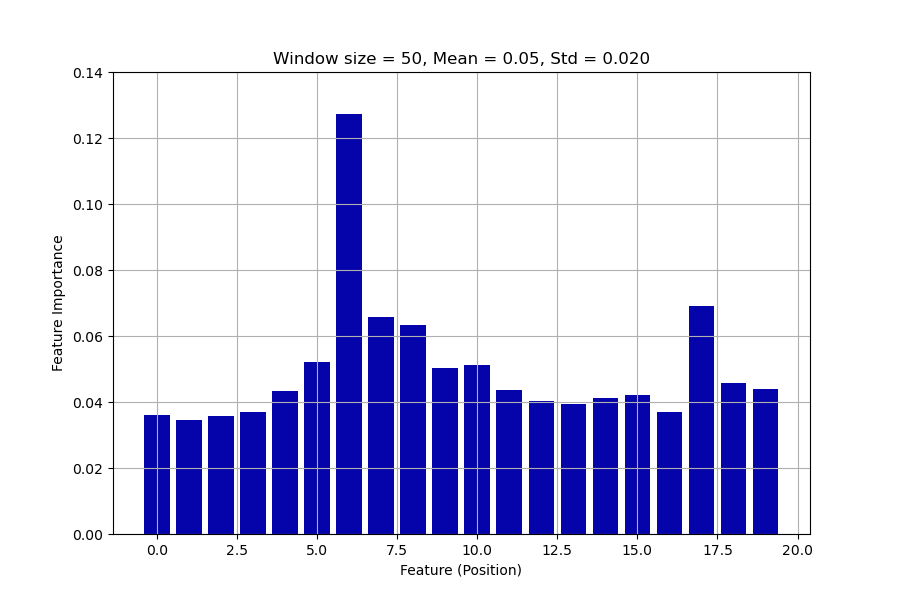

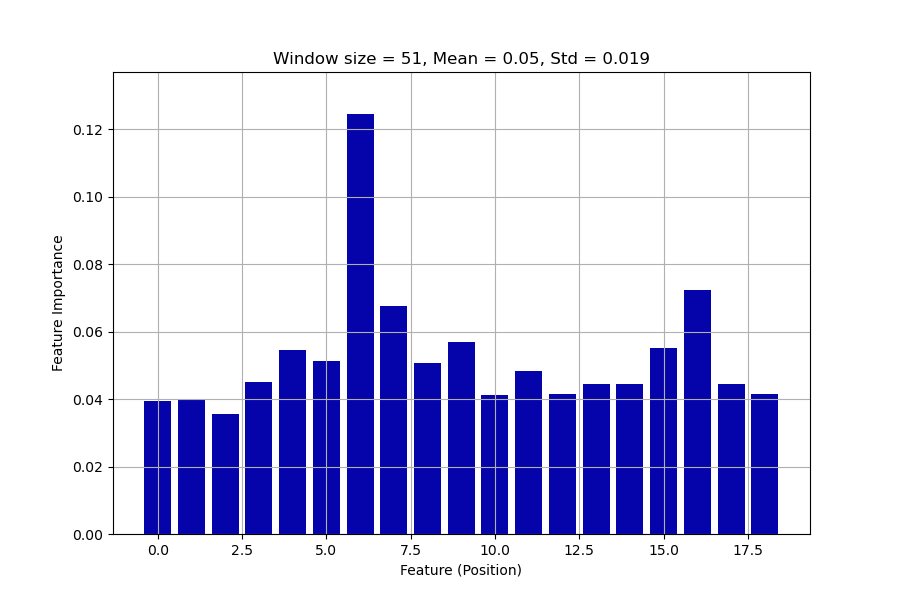

In [11]:
# Display the saved feature importance plots in the notebook
trainer.display_feature_importance_plots('XGB_Pos_Imp_Figs')